ระบบแนะนำสินค้า เมื่อลูกค้าเข้าไป shopping สินค้าใดสินค้าหนึ่ง AI จะแนะนำรายการสินค้าอื่นที่คล้ายกันมาให้พิจารณา

In [2]:
#http://archive.ics.uci.edu/ml/machine-learning-databases/00352/
# conda install -c conda-forge tqdm
# pip install tqdm
# pip install openpyxl
# pip install gensim

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm 
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

c:\Users\Taechatuch\anaconda3\envs\mydata\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
#การเลือกคอลัมน์ a ถึง d และคอลัมน์ g 
cols = 'a:d,g' 

df = pd.read_excel("Online Retail.xlsx", usecols=cols, 
                  dtype={'CustomerID':str, 'InvoiceNo':str})

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,17850
1,536365,71053,WHITE METAL LANTERN,6,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,17850


In [5]:
df.sample(10)

,InvoiceNo,StockCode,Description,Quantity,CustomerID
263613,560024,84859A,SILVER DISCO HANDBAG,1,15005
130183,547417,22223,CAKE PLATE LOVEBIRD PINK,9,13239
438566,574328,79321,CHILLI LIGHTS,8,13081
339288,566585,22584,PACK OF 6 PANNETONE GIFT BOXES,6,16409
372042,569230,22361,GLASS JAR DAISY FRESH COTTON WOOL,1,16533
406561,571797,20726,LUNCH BAG WOODLAND,1,NaN
378835,569669,47504K,ENGLISH ROSE GARDEN SECATEURS,1,14730
110685,545693,47566B,TEA TIME PARTY BUNTING,10,16422
219733,556107,22729,ALARM CLOCK BAKELIKE ORANGE,1,17360
443842,574714,22150,3 STRIPEY MICE FELTCRAFT,2,15427


In [6]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,CustomerID
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12680
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12680
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12680
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12680
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12680


ตรวจสอบการคืนสินค้าที่มีเครื่องหมายติดลบ -

In [7]:
df.groupby('Quantity').size()

Quantity
-80995    1
-74215    1
-9600     2
-9360     1
-9058     1
         ..
 4800     1
 5568     1
 12540    1
 74215    1
 80995    1
Length: 722, dtype: int64

ใช้เงื่อนไขตรวจสอบการคืนสินค้ามากกว่า 100 ชิ้น

In [8]:
df[df.Quantity < -100].sort_values('Quantity', ascending=True).head(10)

,InvoiceNo,StockCode,Description,Quantity,CustomerID
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,16446
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,12346
225530,556691,23005,printing smudges/thrown away,-9600,NaN
225529,556690,23005,printing smudges/thrown away,-9600,NaN
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,15838
225528,556687,23003,Printing smudges/thrown away,-9058,NaN
115818,546152,72140F,throw away,-5368,NaN
431381,573596,79323W,"Unsaleable, destroyed.",-4830,NaN
341601,566768,16045,NaN,-3667,NaN
323458,565304,16259,NaN,-3167,NaN


In [9]:
df.describe().round(2)

,Quantity
count,541909.00
mean,9.55
std,218.08
min,-80995.00
25%,1.00
50%,3.00
75%,10.00
max,80995.00


In [10]:
#ตรวจสอบมิติว่ามีข้อมูลกี่รายการ
df.shape

(541909, 5)

ตรวจสอบว่าลูกค้าแต่ละคน (แต่ละ CustomerID) มียอดซื้อสินค้ากี่รายการ 

In [11]:
df.groupby('CustomerID').count().sort_values('InvoiceNo',
           ascending=False).InvoiceNo.head(20)

CustomerID
17841    7983
14911    5903
14096    5128
12748    4642
14606    2782
15311    2491
14646    2085
13089    1857
13263    1677
14298    1640
15039    1508
14156    1420
18118    1284
14159    1212
14796    1165
15005    1160
16033    1152
14056    1128
14769    1094
17511    1076
Name: InvoiceNo, dtype: int64

In [12]:
#ตรวจสอบข้อมูลที่สูญหาย missing data
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
CustomerID     135080
dtype: int64

การเตรียมข้อมูลเบื้องต้น 

In [13]:
#ดูข้อมูลการคืนสินค้าที่จะต้องพิจารณาตัดทิ้ง 
df[df.Quantity < 0].count()


InvoiceNo      10624
StockCode      10624
Description     9762
Quantity       10624
CustomerID      8905
dtype: int64

In [14]:
df[df.Quantity < 0]

,InvoiceNo,StockCode,Description,Quantity,CustomerID
141,C536379,D,Discount,-1,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,17548
...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,14397
541541,C581499,M,Manual,-1,15498
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,15311
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,17315


In [15]:
#ตัดรายการที่คืนสินค้าออก
df = df[df.Quantity > 0]
df.shape

(531285, 5)

เปลี่ยนข้อมูลให้เป็น String เพื่อใช้กับ Word2Vec

In [16]:
df['CustomerID'] = df['CustomerID'].astype(str)
df['StockCode'] = df['StockCode'].astype(str)
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

ตรวจสอบ Invoice ที่มีการซื้อเพียง 1 รายการ จะไม่สร้างความเชื่อมโยงกับสินค้าอื่น ให้พิจารณาตัดทิ้ง 

In [17]:
df_invoice = df.groupby('InvoiceNo').count().Quantity.sort_values()
df_invoice

InvoiceNo
A563187       1
561392        1
561386        1
542145        1
561372        1
           ... 
558475      705
580729      721
581492      731
581219      749
573585     1114
Name: Quantity, Length: 20728, dtype: int64

ทำการตัดทิ้งรายการสินค้าที่มีการซื้อเพียงรายการเดียว 

In [18]:
frame = {'InvoiceNo': df_invoice.index, 'Count': df_invoice.values}

res = pd.DataFrame(frame)
invoices_small = res[res.Count <= 1].InvoiceNo.tolist()
invoices_small[:10]

['A563187',
 '561392',
 '561386',
 '542145',
 '561372',
 '561368',
 '561365',
 '561361',
 '561333',
 '561327']

การเอารายการ list ที่มีอยู่ใน invoice_small ไปตัดออกจากข้อมูลรายการหลัก df 

In [19]:
df = df[df.InvoiceNo.apply(lambda x: x not in invoices_small)]
df.shape

(528911, 5)

ตรวจสอบพบว่า จะเหลือ Invoice ที่มี 2 รายการเท่านั้น 

In [20]:
df.groupby('InvoiceNo').size().sort_values()

InvoiceNo
563208       2
565206       2
565205       2
542889       2
554952       2
          ... 
558475     705
580729     721
581492     731
581219     749
573585    1114
Length: 18354, dtype: int64

การเตรียม Dataset เพื่อใช้ในการ Train โมเดล AI 

In [21]:
customers = df.InvoiceNo.unique().tolist()
print(len(customers)) #จำนวนไป Invoice 
customers[:6] #ตัวอย่างข้อมูล List คือเลข Invoice 

18354


['536365', '536366', '536367', '536368', '536370', '536372']

การแบ่งข้อมูลออกเป็น 2 ส่วน คือสำหรับการ Train และ Validation

In [22]:
# กรณีต้องการสลับตำแหน่ง (Shuffle) customer ให้เปิดใช้ 2 บรรทัดต่อไปนี้ 
# import random
# random.shuffle(customers)

#แบ่งข้อมูลในการ Train 90%
customers_train = [customers[i] for i in range(round(0.9*len(customers)))] 

#แบ่ง data train และ validation set
train_df = df[df['InvoiceNo'].isin(customers_train)]

#validation คือส่วนที่ไม่อยู่ใน customers_train
validation_df = df[~df['InvoiceNo'].isin(customers_train)]

In [23]:
train_df

,InvoiceNo,StockCode,Description,Quantity,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,17850
1,536365,71053,WHITE METAL LANTERN,6,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,17850
...,...,...,...,...,...
479542,577167,23439,HAND WARMER RED LOVE HEART,4,16511
479543,577167,22834,HAND WARMER BABUSHKA DESIGN,2,16511
479544,577168,22423,REGENCY CAKESTAND 3 TIER,56,12603
479545,577168,POST,POSTAGE,7,12603


การใช้ tqdm เพื่อแสดง Progress bar 

In [24]:
purchase_train = []

# for i in customers_train: # ถ้าไม่ใช้ tqdm
for i in tqdm(customers_train): #ใช้ tqdm แสดง % ของ progress bar 
    temp = train_df[train_df.InvoiceNo == i]['StockCode'].tolist()
    purchase_train.append(temp)


100%|██████████| 16519/16519 [11:46<00:00, 23.39it/s]


การ Train โมเดล และการสร้างมอนิเตอร์ Callback เพื่อรายงานความก้าวหน้าในขณะที่ Train โมเดล 

In [25]:
#การสร้างมอนิเตอร์ Callback เพื่อรายงานความก้าวหน้าของ Epoch ในขณะที่ Train โมเดล 

from IPython.display import clear_output

#คลาสสำหรับมอนิเตอร์แต่ละ Epoch (Callback)
class MonitorCallback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        clear_output(wait=True)
        print('Start...')
    
    def on_epoch_begin(self, model):
        pass 
        #print('Epoch start')
    
    def on_epoch_end(self, model):
        clear_output(wait=True)
        print('Epoch #{}/{}'.format(self.epoch+1, model.epochs)) #แสดงรอบการ Train
        self.epoch += 1

monitor = MonitorCallback()

#ทำการ Train โมเดล 
model = Word2Vec(purchase_train, vector_size=50, window=5,
                sg=1, workers=4, epochs=40, callbacks=[monitor])

Epoch #40/40


In [26]:
#vocab คือจำนวนรหัสสินค้า (StockCode) เนื่องจากใช้รหัสสินค้าเป็นคำ หรือ vocab ในการ Train 
print(model)

Word2Vec<vocab=3414, vector_size=50, alpha=0.025>


In [27]:
#ตรวจสอบว่าในโมเดล มีรหัสสินค้าอะไรบ้าง 
model.wv.index_to_key[:6]

['85123A', '85099B', '22423', '47566', '20725', '84879']

In [28]:
#ตรวจสอบเวกเตอร์ของสินค้า 
model.wv['22423']

array([-0.51269984,  0.11958496,  0.00414081,  0.18322952,  0.17424464,
       -0.2255136 ,  0.20837617, -0.08028978, -0.3468097 , -0.25205544,
       -0.5057273 , -0.20947315,  0.4660885 ,  0.24476872,  0.3805952 ,
        0.13975409,  0.30682805,  0.09305061, -0.13582551, -0.38401222,
       -0.30956382, -0.1592972 ,  0.3564145 , -0.2756034 ,  0.03297355,
        0.12263505, -0.12099301, -0.15860513, -0.0650375 , -0.2176955 ,
        0.5744074 , -0.14881174,  0.34259447, -0.18630224, -0.22751823,
       -0.13403167,  0.23391931,  0.82858074,  0.10664739,  0.2533603 ,
        0.09662908,  0.28087234, -0.43880895,  0.21581322,  0.4897068 ,
        0.0254067 , -0.24564184, -0.14055906,  0.16257404,  0.08109956],
      dtype=float32)

บันทึก model ไว้ใช้งาน คือสามารถนำ model ไปแนะนำสินค้าได้

In [29]:
model.save('amazon_store.model')

การแนะนำสินค้า คือการนำ model ไปใช้งาน เพื่อแนะนำสินค้า โดยหาค่าความคล้ายกันของรหัสสินค้า

In [30]:
#การหาค่าความคล้ายกันมากที่สุดของรายการสินค้า 5 อันดับแรก

model.wv.most_similar('22613', topn=5)

[('22631', 0.6828837394714355),
 ('22629', 0.6457213163375854),
 ('22614', 0.6364689469337463),
 ('22630', 0.6270318627357483),
 ('21987', 0.5911484956741333)]

การสร้าง dictinary เพื่อแสดงรายการสินค้า ทีี่มี key-value เป็น StockCode: Description

In [31]:
products = train_df[['StockCode', 'Description']]

#ลบส่วนที่ซ้ำกันออก (Remove duplicates)
products.drop_duplicates(inplace=True, subset='StockCode', keep='last')
products[:5]

C:\Users\Taechatuch\AppData\Local\Temp\ipykernel_7444\4008043085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products.drop_duplicates(inplace=True, subset='StockCode', keep='last')


,StockCode,Description
107,84854,GIRLY PINK TOOL SET
2313,82615,PINK MARSHMALLOW SCARF KNITTING KIT
4116,35271S,GOLD PRINT PAPER BAG
4582,21268,VINTAGE BLUE TINSEL REEL
5024,16161M,WRAP PINK FLOCK


In [32]:
#สร้าง dictionary StockCode:Description และการทดสอบการค้นชื่อจากรหัสสินค้า 

products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()
products_dict['22139']

['RETROSPOT TEA SET CERAMIC 11 PC ']

ทำการแนะนำสินค้า สมมุติว่าลูกค้ากำลังชมสินค้ารหัส '84997B' อยู่ ระบบจะนำรหัสสินค้าดังกล่าว ไปเข้า model หาว่าสินค้าตัวใดมีค่าความคล้ายกันมากทีี่สุด

In [33]:
sku_now = '84997B' #'15044C'
similarity = model.wv.most_similar(sku_now, topn=7)

print('Shopping', sku_now, products_dict[sku_now][0])
print('--------------------------------------')

for i in similarity:
    if i[1] > 0.6:
        print('{:6} {:36} {:.3f}'.format(i[0], products_dict[i[0]][0], i[1]))


Shopping 84997B CHILDRENS CUTLERY RETROSPOT RED 
--------------------------------------
84997D CHILDRENS CUTLERY POLKADOT PINK      0.962
84997C CHILDRENS CUTLERY POLKADOT BLUE      0.945
84997A CHILDRENS CUTLERY POLKADOT GREEN     0.907
23256  CHILDRENS CUTLERY SPACEBOY           0.699
23254  CHILDRENS CUTLERY DOLLY GIRL         0.687
23255  CHILDRENS CUTLERY CIRCUS PARADE      0.663
21243  PINK POLKADOT PLATE                  0.656


การแนะนำสินค้า เป็นลักษณะคู่กัน เช่น ถ้าจะซื้อนมผง ต้องซื้ออะไรด้วยเป็นต้น 

In [34]:
similars = model.wv.most_similar(['84997B', '22139'], topn=7)
similars

[('84997C', 0.8048321604728699),
 ('84997D', 0.7997751832008362),
 ('23254', 0.7477673888206482),
 ('22138', 0.7464337944984436),
 ('84997A', 0.7245040535926819),
 ('23256', 0.7165073752403259),
 ('23255', 0.707794725894928)]

การ Plot กราฟแสดงความสัมพันธ์ของจุดสินค้า 

In [35]:
#การนำรหัสสินค้ามาเก็บไว้ใน list labels

labels = np.asarray(model.wv.index_to_key)
labels.shape

(3414,)

In [36]:

#การแสดง list labels 10 รายการ
labels[:10]

array(['85123A', '85099B', '22423', '47566', '20725', '84879', '22720',
       '21212', '22383', '22197'], dtype='<U12')

In [37]:
#การนำเวกเตอร์ของสินค้าทั้งหมดมาเก็บไว้ใน vectors เพื่อเตรียม Plot 
vectors = np.asarray(model.wv.vectors)
vectors.shape

(3414, 50)

การเลือก Plot กราฟบางรายการ เพราะถ้านำมาทั้งหมดจะมีข้อมูลมากเกินไป 

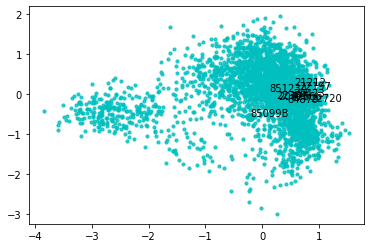

In [38]:
lst_chk = ['85123A', '85099B', '22423', '47566', '20725', '84879', '22720',
           '21212', '22383', '22197']

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
result =- pca.fit_transform(vectors)
plt.figure(figsize=(6, 4))
plt.scatter(result[:, 0], result[:, 1], s=10, alpha=.8, c='c')

#พล็อตจุดและข้อความเวกเตอร์ เฉพาะสินค้าที่สนใจ (ในตัวแปร lst_chk เท่านั้น)
for i, label in enumerate(labels):
    if label in lst_chk:
        plt.scatter(result[i][0], result[i][1], s=70, c='c')
        plt.annotate(label, xy=(result[i, 0]+.005, result[i, 1]+.005))

plt.show()